### `setup`

In [70]:
import matplotlib.pyplot as plt
import pygraphviz
import networkx as nx
from IPython.display import Image

def makeGraph(nodes=None, edges=None, digraph=False):
  if digraph: g = nx.DiGraph()
  else:       g = nx.Graph()
  if nodes:   g.add_nodes_from(nodes)
  if edges:   g.add_edges_from(edges)
  return g


def showGraph(g, name='temp', graphviz=True, prog='dot', weights=False):
  """ g        : networkx graph object
      name     : defines dot/png temporary filenames
      graphviz : if False uses networkx display, otherwise uses Graphviz's
      prog     : defines Graphviz's layout engine (egs: dot, neato)
      weights  : if True add weights to graph display
  """
  if graphviz:
    for node in g.nodes():
      g.nodes[node]['width'] = 0.5
    if weights:
      # for graphviz, nodes/edges with a label attr will be printed
      for edge in g.edges():
        g.edges[edge]['label'] = g.edges[edge]['weight']
    A = nx.nx_agraph.to_agraph(g)
    A.draw(f'{name}.png', prog=prog, args='-Gnodesep=0.2 -Granksep=0.25') # write graph as a png file
    A.write(f'{name}.dot')           # write graph in DOT notation
    display(Image(f'{name}.png'))    # display image
  else:
    options = { # https://networkx.org/documentation/latest/auto_examples/basic/plot_simple_graph.html
        "font_size": 12,
        "node_size": 1000,
        "node_color": "white",
        "edgecolors": "black",
        "linewidths": 1,
        "width": 1,
        "with_labels": True,
    }
    pos = nx.nx_pydot.graphviz_layout(g, prog=prog)  # get node positions to place labels
    nx.draw_networkx(g, pos, **options)
    # format color for nodes
    colors = [g.nodes[n].get('color', 'white') for n in g.nodes]
    nx.draw_networkx_nodes(g, pos, node_color=colors)
    # format color and width for edges
    colors = [g.edges[a,b].get('color', 'black') for a,b in g.edges]
    widths = [g.edges[a,b].get('width', 1)       for a,b in g.edges]
    labels = [g.edges[a,b].get('label', '')      for a,b in g.edges]
    nx.draw_networkx_edges(g, pos, edge_color=colors, width=widths, label=labels)
    # draw weights
    if weights:
      labels = nx.get_edge_attributes(g, 'weight')
      nx.draw_networkx_edge_labels(g, pos, edge_labels=labels)
    ax = plt.gca()
    ax.margins(0.20)
    plt.axis("off")
    plt.show()    



---



# Chapter - Graphs

João Pedro Neto, DI/FCUL

## Introduction

The tree type is a way to generalize the list type, a data structure that has more than one successor for each stored element. This generalization is reflected in a more complex representation of a tree in memory, compared to the simplicity of representing a list. But this cost comes with an important advantage: we can use trees to solve a greater number of problems and, in certain cases, even improve the complexity of solutions to certain problems.

In this chapter, we take a new step in this generalization: each stored element can have multiple successors (like a tree) but also multiple predecessors (including themselves!). Structures with this organization we will refer to as **graphs**. And as you would expect, we will be able to solve many new problems with this type of data.

<center><img src='https://raw.githubusercontent.com/jpneto/Prog.I/master/imgs/ex_graph.png' width=700px></center>

A graph is a way to represent relationships between pairs of objects. This idea has applications in multiple domains. The relationship between:

+ two cities describes (for example) the existence of a road that connects them
+ two people represents a degree of friendship
+ two tasks signifies a precedence constraint
+ two airports indicates a direct connection
+ two functions in a Python program suggests that one calls the other

and so on...

Another perspective is to view a graph as the representation of different states of a problem and how these states can evolve into subsequent states. For example, the behavior of a traffic light can be modeled by a graph that has three states (green, yellow, and red) and describes how these states change over time (from green to yellow, from yellow to red, from red to green).

Here is some terminology related to graphs:

- In graphs, we refer to the elements stored in the graph as **nodes** or **vertices**.

- The connections between nodes are called **edges**.

- A **graph** is composed of a finite set of nodes and a finite set of edges, where each edge connects a pair of nodes in the graph. By the definition of a set, in a graph there cannot be two identical edges.

- Two nodes separated by an edge are called **adjacent** or **neighbors**.

- The **degree** of a node is the number of its neighbors.

- A **path** is a sequence of nodes $N_1, N_2, \ldots, N_p$ where each pair $(N_i, N_{i+1})$ is an edge.

- A **cycle** is a path that starts and ends at the same node (with no repeating intermediate nodes).

- A graph is **acyclic** if it does not contain cycles.

- A **component** is a set of nodes that are adjacent to each other without any additional nodes connected to them.

- A graph is **connected** if it has only one component or **disconnected** if it has multiple components.

- If the direction of edges is relevant, it is called a **directed graph** or **oriented graph**.

For directed graphs, the following terminology and concepts apply:

- A node $N$ is a **successor** of node $M$ if and only if the edge $(M, N)$ belongs to the graph. It is also said that $M$ is a **predecessor** of $N$.

- A node $N$ is **accessible** from another node $M$ if and only if there is a path from $M$ to $N$.

- The **descendants** of node $M$ are the set of nodes that are accessible from $M$.

- The **ancestors** of node $M$ are the set of nodes from which you can access $M$.

- A **weakly connected component** is a set of connected nodes without considering the directions of the edges, while a **strongly connected component** is a set of nodes that are mutually connected considering the directions of the edges.

For example, in the following directed graph, nodes $2$ and $4$ are successors of $3$. The descendants of $4$ are nodes $2$ and $3$, and node $1$ is not accessible from $4$. Nodes $3$ and $4$ belong to the same strongly connected component.

<center><img src='https://raw.githubusercontent.com/jpneto/Prog.I/master/imgs/ex_graph2.png' width=250px></center>

A tree is a particular case of a graph. A graph in the form of a tree:

- is a connected and acyclic graph.
- if it has $n$ nodes, it will necessarily have $n-1$ edges.
- the removal of any edge makes the graph disconnected.
- adding a new edge makes the graph cyclic.
- there is only one possible path that connects any two nodes.

## Implementing and Visualizing Graphs

There are two common ways to represent a graph in memory:

- Using an **adjacency list**, where, for each node with index `i`, a list is stored containing the indices of its neighboring nodes.

For example, if we want to represent the graph from the image above, the list would be:

In [71]:
g = [[1,2], [], [1,3], [2]] # index zero represents node 1, etc.

+ Using an **adjacency matrix**, where each position `i, j` has the value $1$ if there is an edge between the node with index `i` and the node with index `j`, or the value $0$ if there is no such edge.

<center><img src='https://raw.githubusercontent.com/jpneto/Prog.I/master/imgs/ex_graph2.png' width=150px></center>

Using the same graph:

In [72]:
g = [[0,1,1,0],  # row i, column j is 1 iff (i,j) ∈ graph
     [0,0,0,0],
     [0,1,0,1],
     [0,0,1,0]]

The adjacency matrix has the advantage of simplicity in dealing with its data structure, but it incurs excessive memory costs, especially in the case of graphs with few edges relative to its number of nodes.

However, we will not develop a Graph ADT (Abstract Data Type) here, nor its specification or the associated API. This means we won't be concerned with the problem of representing a graph in memory or implementing the public service that the API would require.

Our focus will be on discussing traditional graph algorithms and how they are useful in problem-solving. The examples presented will show that it is possible to use graphs to model very different types of problems.

In this context, we have chosen to use a graph module available in the Python ecosystem, the `networkx` [module](https://networkx.org/).

In [73]:
import networkx as nx

Two functions have also been defined (cf. setup) to facilitate the task of creating and visualizing graphs: `makeGraph` and `showGraph`.

- The `makeGraph` function can take a sequence of node names and/or a sequence of edge pairs as input. Additionally, there is a parameter called `digraph` that indicates whether the graph to be created is directed or not.

- The `showGraph` function displays the structure of the graph and has various visualization parameters (which can be found in the function's definition).

A use case with a list of edges:

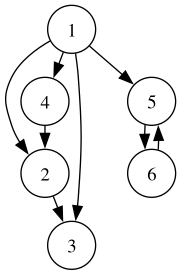

In [74]:
g = makeGraph(edges=[(1,2),(4,2),(2,3),(1,3),(1,4),(1,5),(5,6),(6,5)], digraph=True)
showGraph(g)

It is also possible to add other visual elements, as shown in the following example:

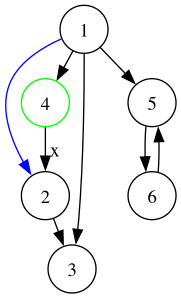

In [75]:
g.nodes[4]['color']    = 'green' # add color to node
g.edges[1, 2]['color'] = 'blue'  # add color to edge
g.edges[4, 2]['label'] = ' x'    # associate a label to an edge
showGraph(g)

## Basic Graph Operations

The following sections show several functions to retrieve information about a graph and its nodes.

### Directed Graphs

Using the previous graph as an example, let's observe the results of the operations that are available to us:

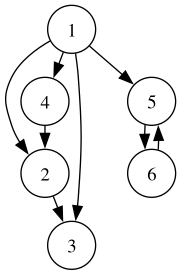

In [76]:
g = makeGraph(edges=[(1,2),(4,2),(2,3),(1,3),(1,4),(1,5),(5,6),(6,5)], digraph=True)
showGraph(g)

+ `successors` returns the successors of a given node

In [77]:
[(node, list(g.successors(node))) for node in g]

[(1, [2, 3, 4, 5]), (2, [3]), (4, [2]), (3, []), (5, [6]), (6, [5])]

+ `predecessors` return the predecessors of a given node

In [78]:
[(node, list(g.predecessors(node))) for node in g]

[(1, []), (2, [1, 4]), (4, [1]), (3, [2, 1]), (5, [1, 6]), (6, [5])]

+ `descendants` and `ancestors` return, respectively, all descendants and ancestors of a given node

In [79]:
[(node, list(nx.descendants(g, node))) for node in g]

[(1, [2, 3, 4, 5, 6]), (2, [3]), (4, [2, 3]), (3, []), (5, [6]), (6, [5])]

In [80]:
[(node, list(nx.ancestors  (g, node))) for node in g]

[(1, []), (2, [1, 4]), (4, [1]), (3, [1, 2, 4]), (5, [1, 6]), (6, [1, 5])]

+ `weakly_connected_components` returns the graph's weakly connected components

In [81]:
list(nx.weakly_connected_components(g))

[{1, 2, 3, 4, 5, 6}]

+ `strongly_connected_components` returns the graph's strongly connected components

In [82]:
list(nx.strongly_connected_components(g))

[{3}, {2}, {4}, {5, 6}, {1}]

For a directed graph with $V$ nodes and $E$ edges, the complexities of the last two functions, regarding components, are $\mathcal{O}(V+E)$.

### Undirected Graphs

For undirected graphs there is function `neighbors` that returns the adjacent nodes of a given node,

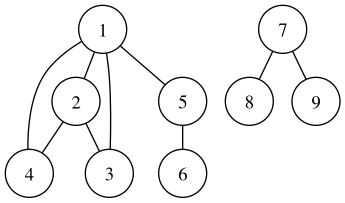

neighbors of node 1: 2 3 4 5
neighbors of node 2: 1 4 3
neighbors of node 3: 2 1
neighbors of node 4: 2 1
neighbors of node 5: 1 6
neighbors of node 6: 5
neighbors of node 7: 8 9
neighbors of node 8: 7
neighbors of node 9: 7


In [83]:
g1 = makeGraph(edges=[(1,2),(4,2),(2,3),(1,3),(1,4),(1,5),(5,6),(7,8),(7,9)])
showGraph(g1)

for node in range(1,10):
  print(f'neighbors of node {node}:', *list(nx.neighbors(g1, node)))

Function `connected_components` returns the different components of an undirected graph, with complexity $\mathcal{O}(V+E)$:

In [84]:
[list(c) for c in nx.connected_components(g1)]

[[1, 2, 3, 4, 5, 6], [8, 9, 7]]

The function allow us to create copies of each component:

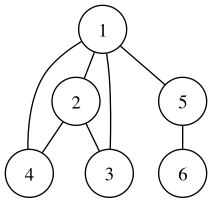

In [85]:
sub_graphs = [g1.subgraph(c).copy() for c in nx.connected_components(g1)]
showGraph(sub_graphs[0])

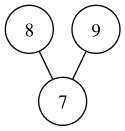

In [86]:
showGraph(sub_graphs[1])

## Weighted Graphs

A significant graph variant involves numerical values associated with their edges. These values model costs associated with the respective edges. For example, it is typical to define the cost of a path as the sum of the weights of its edges.

These costs are useful for solving optimization tasks, as we will see some examples in future sections.

How to create a weighted graph using `networkx`:

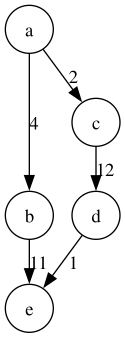

In [87]:
g = nx.DiGraph()              # make an empty graph
g.add_edge('a','b', weight=4) # attribute 'weight' defines the edge's value
g.add_edge('a','c', weight=2)
g.add_edge('c','d', weight=12)
g.add_edge('d','e', weight=1)
g.add_edge('b','e', weight=11)

showGraph(g, weights=True)    # weights=True shows all edge's weights

Function `path_weight` computes the total cost of a given path:

In [88]:
nx.path_weight(g, 'acde', 'weight')

15

## Standard Graph Operations

Let's introduce a set of well-known operations that make problem-solving easier through the use of graphs.

When discussing the complexity of these operations, we assume a graph with $V$ nodes and $E$ edges.

### Depth-first Search

One of the most fundamental tasks involving graphs is to traverse all of their nodes. And, just like in trees, there are several alternatives for traversing a graph.

One of these traversals is called [Depth-first Search](https://en.wikipedia.org/wiki/Depth-first_search) (DFS). This concept has already been discussed in the chapter on search.

The algorithm for applying DFS to a graph is as follows: choose a vertex and move in-depth through any neighbor. It's essential to keep track of the visited nodes to avoid infinite cycles (something that didn't happen in trees). When you reach a dead end (all neighboring vertices have already been visited), you backtrack and continue along a path with unvisited nodes. When all nodes have been visited, the traversal is complete.

The following function implements this algorithm with a time complexity of $\mathcal{O}(V+E)$, using a stack to keep track of neighboring nodes that haven't been visited yet.

In [89]:
def dfsGraph(g, start):    # «start» is the initial starting node
  result, visited, stack = [], set(), [start]
  while stack != []:
    node = stack.pop()      # using a list as stack
    if node not in visited: # if current node is not visited,
      result.append(node)   #   add node to DFS path of nodes, and
      visited.add(node)     #   add node to visited nodes (prevents repeated visits)
      # sorted() so smaller neighbors are visited first (it's a stack)
      for sucessor in sorted(nx.neighbors(g, node), reverse=True):
        stack.append(sucessor)
  return result

A use case:

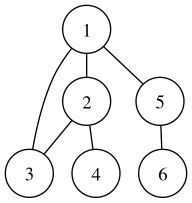

In [90]:
g = makeGraph(edges=[(1,2),(4,2),(2,3),(1,3),(1,5),(5,6)])
showGraph(g)

In [91]:
for node in dfsGraph(g, 2): # start DFS at node 2
  print(node, end=' ')

2 1 3 5 6 4 

As to be expected, module `networkx` includes this operation in function `dfs_tree`:

In [92]:
for node in nx.dfs_tree(g, 2):
  print(node, end=' ')

2 1 3 5 6 4 

### Breadth-first Search

[Breadth-first Search](https://en.wikipedia.org/wiki/Breadth-first_search) (BFS) is similar to Depth-first Search, but it prioritizes neighboring nodes before traversing the successors of those neighbors.

The way to implement BFS is to use a queue instead of a stack. This way, you implement a First-In-First-Out (FIFO) system that allows neighboring vertices of the initial node to be visited first.

The following function implements Breadth-first Search with a time complexity of $\mathcal{O}(V+E)$:

In [93]:
from collections import deque # to remove at deque's begin, and add at its end

def bfsGraph(g, start):
  result, visited, queue = [], set(), deque()
  queue.append(start)
  while queue:
    node = queue.popleft()  # popleft() and append() are both O(1)
    if node not in visited:
      result.append(node)
      visited.add(node)
      # sorted() so smaller neighors are visited first
      for sucessor in sorted(nx.neighbors(g, node)):
        queue.append(sucessor)
  return result

A use case:

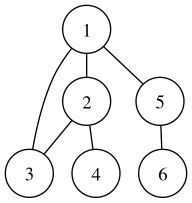

In [94]:
g = makeGraph(edges=[(1,2),(4,2),(2,3),(1,3),(1,5),(5,6)])
showGraph(g)

In [95]:
for node in bfsGraph(g, 2):
  print(node, end=' ')

2 1 3 4 5 6 

Using `networkx`,

In [96]:
for node in nx.bfs_tree(g, 2):
  print(node, end=' ')

2 1 4 3 5 6 

### Topologic Sort

[Topological Sort](https://en.wikipedia.org/wiki/Topological_sorting) is a linear ordering of the nodes in a graph. This operation provides a way to «flatten» a graph into a list of nodes.

Converting a graph into a list of nodes does involve some loss of information, but for certain problems, it can be sufficient. A typical example occurs when the graph models various tasks, with edges representing mandatory precedences. In other words, an edge $(A, B)$ would mean that task $A$ must be completed before task $B$ can begin. In these situations, topological sorting provides a solution for how to execute the tasks sequentially without violating the precedences imposed by the graph's structure.

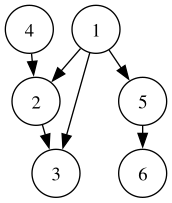

In [97]:
g = makeGraph(edges=[(1,2),(4,2),(2,3),(1,3),(1,5),(5,6)], digraph=True)
showGraph(g)

To return a topological sort, you can execute the following algorithm with a time complexity of $\mathcal{O}(V + E)$:

1. Start with an empty topological order.

2. While there are nodes in the graph:
   1. Find a node that has no predecessors.
   2. Append that node to the end of the topological order.
   3. Remove that node from the graph, along with its edges.

3. Return the topological order.

The following function implements this algorithm:

In [98]:
def topsort(g):
  sort = []
  g = g.copy()                   # don't modify original graph, work in a copy
  while g.number_of_nodes() > 0:
    for node in g.nodes:
      if g.in_degree(node) == 0: # if node has no ancestors
        sort.append(node)        #  add node to result, and
        g.remove_node(node)      #  remove it from graph
        break
  return sort

Let's check the sorting result using the previous graph,

In [99]:
for node in topsort(g):
  print(node, end=' ')

1 4 2 3 5 6 

Without surprise, topological sort is also available in `networkx`,

In [100]:
for node in nx.topological_sort(g):
  print(node, end=' ')

1 4 5 2 6 3 

### Minimal Spanning Tree

A [Minimum Spanning Tree](https://en.wikipedia.org/wiki/Minimum_spanning_tree) (MST) of a graph G is a tree that contains all the nodes of G and has the minimum possible sum of its edges.

This procedure is useful in situations where each edge has a construction cost, and you want to minimize the cost of the edges without disconnecting the graph. To do this, you choose a subset of the initial edges and create an MST, which connects all the nodes while minimizing the total edge cost.

The MST can be computed using [Kruskal's algorithm](https://en.wikipedia.org/wiki/Kruskal's_algorithm), which follows these steps:

1. Create a set of trees T, where each tree is a node in the graph.

2. Create a set S with all the edges from the graph.

3. While S has elements and T is not yet a spanning tree (i.e., it doesn't include all nodes):

   1. Remove the edge with the minimum weight from S.

   2. If this edge connects two trees in T, add the edge to combine them.

This algorithm finds the minimum spanning tree by iteratively selecting edges with the lowest weights and adding them to the growing spanning tree, ensuring that it remains acyclic and connects all nodes.

<center><img src='https://raw.githubusercontent.com/jpneto/Prog.I/master/imgs/graph_Kruskal_algorithm.gif' width=250px><br/><i>wikipedia</i></center>   

The algorithm has complexity $\mathcal{O}(E \log E)$.

An example:

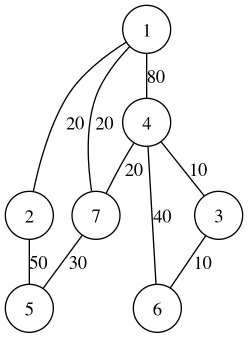

In [101]:
g = nx.Graph()
edges = [(1,2,20),(1,4,80),(1,7,90),(3,4,10),(3,6,50),(4,3,10),
         (4,7,20),(5,2,50),(5,7,30),(6,3,10),(6,4,40),(7,1,20)]
for a,b,w in edges:
  g.add_edge(a,b, weight=w)

showGraph(g, weights=True)

Function `minimum_spanning_tree` returns a list of edges defining the MST of a given graph.

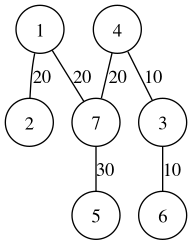

totalCost: 110


In [102]:
mst = nx.minimum_spanning_tree(g)
showGraph(mst)

print('totalCost:', sum(mst.edges[edge]['weight'] for edge in mst.edges))

### Hamiltonian Path

Suppose you needed to find a path that traverses all nodes of a graph, exactly once. These paths are called [Hamiltonian paths](https://en.wikipedia.org/wiki/Hamiltonian_path), and for certain graphs, there may not be a solution.

We can use the tools from the search chapter to accomplish this task:

In [103]:
from src.cap14 import TreeSearchProblem, dfs

class HamiltonianPath(TreeSearchProblem):
  def __init__(self, g, node):
    self._g = g
    self._node = node # starting node

  def start(self):
    return (self._node,)

  def is_goal(self, state):
    return len(state) == self._g.number_of_nodes()

  def next_moves(self, state):
    currentNode = state[-1]
    return [state+(nextNode,) for nextNode in nx.neighbors(self._g, currentNode)
                              if nextNode not in state]

ModuleNotFoundError: No module named 'src'

A use case,

In [ ]:
g = makeGraph(edges=[(1,2),(4,2),(2,3),(1,3),(1,4),(1,5),(5,6),(4,6)])

sol = next(dfs(HamiltonianPath(g,1)))
for node in sol[-1]:
  print(node, end=' ')

1 5 6 4 2 3 

The `networkx` module does not have a function for calculating the Hamiltonian path. This is likely because the Hamiltonian path problem is not polynomial and can only be solved through brute-force search.

### Eulerian Path

Here, we aim to find a path that traverses all the edges of the graph (if possible). This was the original problem that motivated the development of Graph Theory by Leonhard Euler (by the way, the greatest mathematician of all time!). It's the same problem that's famously known as the [Seven Bridges of Königsberg](https://en.wikipedia.org/wiki/Seven_Bridges_of_K%C3%B6nigsberg).

A necessary condition for the existence of an Eulerian path, in an undirected graph, is that only zero or two nodes must have an odd degree -- all the others must have even degrees so that every time the path enters an intermediate node, it can also exit from it.

There are [several algorithms](https://en.wikipedia.org/wiki/Eulerian_path) that calculate one of these possible paths in $\mathcal{O}(E)$.

<!-- A [documentação](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.euler.eulerian_circuit.html#rc2b6c82f50dc-1) lista a referência do algoritmo usado. -->

In [ ]:
g = makeGraph(edges=[(1,2),(2,3),(1,3),(1,4),(1,5),(5,6),(4,6)])
showGraph(g)

In [ ]:
for node in nx.eulerian_circuit(g):
  print(node, end=' ')

(1, 5) (5, 6) (6, 4) (4, 1) (1, 3) (3, 2) (2, 1) 

The next animation shows the path found by the algorithm:

In [ ]:
# Eulerian path animation
from ipywidgets import interact, widgets

def show(g, circuit, passo):
  for a,b in g.edges:
    g.edges[(a,b)]['color'] = 'black'
    g.edges[(a,b)]['width'] = 1
  g.edges[circuit[passo]]['width'] = 2
  g.edges[circuit[passo]]['color'] = 'red'
  display(showGraph(g))

circuit = list(nx.eulerian_circuit(g))
interact(lambda step : show(g, circuit, step),
         step = widgets.IntSlider(min=0, max=len(circuit)-1, value=0,
                                  continuous_update = False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='step', max=6), Output()), _dom_…

### Shortest Path

If the graph has edge weights, it's common to want to minimize the total cost of the path between two nodes. As expected, we need to explore various alternatives until finding the optimal path.

Given the graph,

In [ ]:
g = nx.DiGraph()
edges = [(1,2,20),(1,4,80),(1,7,90),(2,6,10),(3,4,10),(3,8,20),(3,6,50),
         (4,3,10),(4,7,20),(5,2,50),(5,7,30),(6,3,10),(6,4,40),(7,1,20)]
for a,b,w in edges:
  g.add_edge(a,b, weight=w)

showGraph(g, weights=True)

if we wish to move from node $1$ to node $8$ there are several possible paths:

+ $1 \rightarrow 4  \rightarrow 3  \rightarrow 8$ with a total cost of $110$

+ $1 \rightarrow 2  \rightarrow 6 \rightarrow 4 \rightarrow 3  \rightarrow 8$, with a total cost of $100$

+ etc.

There are several algorithms that compute the shortest path between two nodes on a weighted graph:

+ [Dijkstra's algorithm](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm), works with non-negative weights, $\mathcal{O}(E + V \log V)$

+ [Bellman-Ford algorithm](https://en.wikipedia.org/wiki/Bellman%E2%80%93Ford_algorithm), is slower but the weights can be negative, $\mathcal{O}(V \cdot E)$

+ [Floyd-Warshall algorithm](https://en.wikipedia.org/wiki/Floyd%E2%80%93Warshall_algorithm), finds the shortest paths costs between all pairs of nodes, $\mathcal{O}(V^3)$

+ [Johnson's algorithm](https://en.wikipedia.org/wiki/Johnson%27s_algorithm),  finds the shortest paths between all pairs of nodes, $\mathcal{O}(V^2 \log V + E \cdot V)$

Let's implement the most famous one, Dijkstra's algorithm [[ref](https://bradfieldcs.com/algos/graphs/dijkstras-algorithm/)]:

In [ ]:
from heapq import heappop, heappush # priority queue (for faster access)
from math import inf as oo

def shortest_path_dijkstra(g, start):
  """ returns the shortest distances from 'start' node to all graph nodes """
  # dist[a] is the shortest distance, so far, from 'start' to node 'a'
  distances = {node: 0 if node==start else +oo for node in g.nodes}
  pq = [(0,start)]

  while pq:
    dist, node = heappop(pq)    # node with smaller distance from those visited
    if dist <= distances[node]: # only need to check shorter paths (greedy)
      for neighbor in nx.neighbors(g, node):
        neighbor_distance = dist + g[node][neighbor]['weight']
        if neighbor_distance < distances[neighbor]:    # a shorter path was found
          distances[neighbor] = neighbor_distance       # keep it,
          heappush(pq, (neighbor_distance, neighbor) )  # and explore it

  return distances

shortest_path_dijkstra(g, 1)

{1: 0, 2: 20, 4: 50, 7: 70, 6: 30, 3: 40, 8: 60, 5: inf}

`networkx` includes all these algorithms:

In [ ]:
nx.shortest_path(g, 1, 8, weight='weight', method='dijkstra')

[1, 2, 6, 3, 8]

In [ ]:
nx.shortest_path(g, 1, 8, weight='weight', method='bellman-ford')

[1, 2, 6, 3, 8]

In [ ]:
for a,b in nx.floyd_warshall(g).items():
  print(f'paths from {a}:', list(b.items())) # (n,x) means it costs x to reach node n

paths from 1: [(1, 0), (2, 20), (4, 50), (7, 70), (6, 30), (3, 40), (8, 60), (5, inf)]
paths from 2: [(2, 0), (6, 10), (1, 70), (4, 30), (7, 50), (3, 20), (8, 40), (5, inf)]
paths from 4: [(4, 0), (3, 10), (7, 20), (1, 40), (2, 60), (6, 60), (8, 30), (5, inf)]
paths from 7: [(7, 0), (1, 20), (2, 40), (4, 70), (6, 50), (3, 60), (8, 80), (5, inf)]
paths from 6: [(6, 0), (3, 10), (4, 20), (1, 60), (2, 80), (7, 40), (8, 30), (5, inf)]
paths from 3: [(3, 0), (4, 10), (8, 20), (6, 50), (1, 50), (2, 70), (7, 30), (5, inf)]
paths from 8: [(8, 0), (1, inf), (2, inf), (4, inf), (7, inf), (6, inf), (3, inf), (5, inf)]
paths from 5: [(5, 0), (2, 50), (7, 30), (1, 50), (4, 80), (6, 60), (3, 70), (8, 90)]


In [ ]:
for a,b in nx.johnson(g).items():
  print(f'paths from {a}:', list(b.items())) # all paths are returned

paths from 1: [(1, [1]), (2, [1, 2]), (4, [1, 2, 6, 3, 4]), (7, [1, 2, 6, 3, 4, 7]), (6, [1, 2, 6]), (3, [1, 2, 6, 3]), (8, [1, 2, 6, 3, 8])]
paths from 2: [(2, [2]), (6, [2, 6]), (3, [2, 6, 3]), (4, [2, 6, 3, 4]), (8, [2, 6, 3, 8]), (7, [2, 6, 3, 4, 7]), (1, [2, 6, 3, 4, 7, 1])]
paths from 4: [(4, [4]), (3, [4, 3]), (7, [4, 7]), (8, [4, 3, 8]), (6, [4, 3, 6]), (1, [4, 7, 1]), (2, [4, 7, 1, 2])]
paths from 7: [(7, [7]), (1, [7, 1]), (2, [7, 1, 2]), (4, [7, 1, 2, 6, 3, 4]), (6, [7, 1, 2, 6]), (3, [7, 1, 2, 6, 3]), (8, [7, 1, 2, 6, 3, 8])]
paths from 6: [(6, [6]), (3, [6, 3]), (4, [6, 3, 4]), (8, [6, 3, 8]), (7, [6, 3, 4, 7]), (1, [6, 3, 4, 7, 1]), (2, [6, 3, 4, 7, 1, 2])]
paths from 3: [(3, [3]), (4, [3, 4]), (8, [3, 8]), (6, [3, 6]), (7, [3, 4, 7]), (1, [3, 4, 7, 1]), (2, [3, 4, 7, 1, 2])]
paths from 8: [(8, [8])]
paths from 5: [(5, [5]), (2, [5, 2]), (7, [5, 7]), (1, [5, 7, 1]), (6, [5, 2, 6]), (4, [5, 2, 6, 3, 4]), (3, [5, 2, 6, 3]), (8, [5, 2, 6, 3, 8])]


The following function returns a path through all the nodes of a graph that minimizes the total cost (the path may pass through the same node multiple times). This variant of the minimum-cost path is known as the [Traveling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem).

Consider the next example,

In [ ]:
g = nx.Graph()
edges = [(1,2,20),(1,4,80),(1,7,90),(3,4,10),(3,6,50),(4,3,10),
         (4,7,20),(5,2,50),(5,7,30),(6,3,10),(6,4,40),(7,1,20)]
for a,b,w in edges:
  g.add_edge(a,b, weight=w)

showGraph(g, weights=True)

Let's compute the shortest path thru all the nodes:

In [ ]:
from networkx.algorithms.approximation import traveling_salesman

# This method provides an approximation (TSP is a hard problem)
# cycle=False, does not need to end where it starts
traveling_salesman.traveling_salesman_problem(g, cycle=False)

[5, 2, 1, 7, 4, 3, 6, 3, 4]

Curiously, the Traveling Salesman Problem is much more computationally demanding, with an exponential complexity of $\mathcal{O}(V \cdot 2^V)$.

### Cycle Detection

We wish to detect cycles in this undirected graph,

In [ ]:
g = nx.Graph()
edges = [(1,2,20),(1,4,80),(1,7,90),(3,4,10),(3,6,50),(4,3,10),
         (4,7,20),(5,2,50),(5,7,30),(6,3,10),(6,4,40),(7,1,20)]
for a,b,w in edges:
  g.add_edge(a,b, weight=w)

showGraph(g, weights=True)

There are several methods available for finding cycles in both directed and undirected graphs.

+ Function `find_cycle` returns a list of edges that make a cycle starting at a given node, the algorithm has complexity $\mathcal{O}(V + E)$:

In [ ]:
nx.find_cycle(g, source=1)

[(1, 2), (2, 5), (5, 7), (7, 1)]

+ Function `cycle_basis` returns all fundamental cycles of a graph, i.e., the simplest cycles that can compose all possible graph cycles. The function has  complexity $\mathcal{O}(E^2\cdot V / \log V)$.

In [ ]:
nx.cycle_basis(g)

[[4, 7, 1], [2, 5, 7, 1], [3, 6, 4]]

+ Function `simple_cycles` returns all cycles of a directed graph with complexity $\mathcal{O}(c(V + E))$, being $c$ the number of cycles.

In [ ]:
g = nx.DiGraph()
for a,b,w in [(1,2,20),(1,4,80),(1,7,90),(3,4,10),(3,6,50),(4,3,10),
              (4,7,20),(5,2,50),(5,7,30),(6,3,10),(6,4,40),(7,1,20)]:
  g.add_edge(a,b, weight=w)

showGraph(g, weights=True)

for cycle in nx.simple_cycles(g):
  print(cycle)

### Transitive Closure and Transitive Reduction

The [transitive closure](https://en.wikipedia.org/wiki/Transitive_closure) of a directed graph is a new directed graph in which, for each node, an edge is added to all of its descendants.

This procedure can be useful if there's the need to repeatedly ask whether a given node is a successor of another. After the transitive closure, we simply check if the nodes in question share an edge. It's a costly process, but needs to be executed only once.

An example:

In [ ]:
g = makeGraph(edges=[(1,2),(4,2),(2,3),(1,5),(5,6),(4,3)], digraph=True)
showGraph(g)

Node $1$ has two sucessors, $3$ and $6$, without direct edges. These will be added by the transitive closure.

In [ ]:
g1 = nx.transitive_closure(g)
showGraph(g1)

[Transitive reduction](https://en.wikipedia.org/wiki/Transitive_reduction), also known as the minimum equivalent graph, is an operation that performs almost the opposite of transitive closure. It removes edges that can be deduced through transitivity. For example, in the previous graph, node 1 doesn't need to have an edge to 6 if another successor, node 5, can reach it.

In [ ]:
g2 = nx.transitive_reduction(g1)
showGraph(g2)

Notice that the original $(4,3)$ edge was also removed. This shows that transitive reduction is not the inverse operation of transitive closure.

Both operations have complexity $\mathcal{O}(V^3)$

### Graph Coloring

Coloring a graph with n colors means assigning a color to each node in such a way that no pair of neighboring nodes share the same color. This is a fundamental problem in graph theory and has many practical applications, such as scheduling and map coloring.

Let's first select some [colors](https://graphviz.org/doc/info/colors.html) available on Graphviz,

In [ ]:
colors = ['green2', 'gold3', 'salmon', 'blue', 'red3', 'darkviolet', 'cyan']

and use the following graph,

In [ ]:
g = makeGraph(edges=[(1,2),(1,4),(1,7),(3,4),(3,6),(4,7),(5,2),(5,7),(6,3),(7,1)])
showGraph(g)

To color it:

In [ ]:
coloring = nx.coloring.greedy_color(g)

for node,i in coloring.items():
  g.nodes[node]['color'] = colors[i]

showGraph(g)

A variant of this problem is to determine whether a graph can be colored with only two colors. A graph with this property is called a [bipartite graph](https://en.wikipedia.org/wiki/Bipartite_graph). In a bipartite graph, you can divide the nodes into two sets, and there are no edges that connect nodes within the same set. Bipartite graphs have numerous applications, such as modeling relationships between two distinct classes of objects.

Let's consider an example where each edge connects an even-numbered node to an odd-numbered node. This graph is necessarily bipartite (can you see why?).

In [ ]:
from networkx.algorithms.bipartite import color, is_bipartite

g = makeGraph(edges=[(1,2),(1,4),(1,6),(3,2),(3,6),(4,1),(4,5),(5,6)])
coloring = color(g)

for node,i in coloring.items():
  g.nodes[node]['color'] = colors[i]

print(is_bipartite(g))
showGraph(g)

In a bipartite graph, you may want to perform a node matching, which means pairing each node with a neighbor of a different color. To achieve this, you can use the `minimum_weight_full_matching` function, which finds the minimum-cost matching (i.e., it minimizes the sum of the selected edges for the matching).

In [ ]:
from networkx.algorithms.bipartite import minimum_weight_full_matching

g = makeGraph(edges=[(1,2),(1,4),(1,6),(3,2),(3,6),(4,1),(4,5),(5,6)])
pairing = minimum_weight_full_matching(g)

for i,(a,b) in enumerate(pairing.items()):
  g.edges[a,b]['color'] = colors[i]
  g.edges[a,b]['penwidth'] = 5
  #g.nodes[a]['style'] = 'filled'
  #g.nodes[a]['fillcolor'] = colors[i]
  #g.nodes[b]['fillcolor'] = colors[i]
showGraph(g)

The `networkx` module has another feature related to graph coloring, the `equitable_color` function. This function aims to use all available colors while trying to color an equal number of nodes for each color. It helps achieve a balanced coloring of the graph with respect to the number of nodes assigned to each color.

In [ ]:
g = makeGraph(edges=[(1,2),(1,4),(1,7),(3,4),(3,6),(4,7),(5,2),(5,7),(6,3),(7,1),(2,8)])
maxDegree = max(degree for _,degree in g.degree())
coloring = nx.coloring.equitable_color(g, num_colors=maxDegree+1)

for node,i in coloring.items():
  g.nodes[node]['color'] = colors[i]

showGraph(g)

## An application: 2-SAT

Let's consider the problem of satisfying a 2-CNF formula, which is a conjunction of disjunctions of two Boolean variables (or their negations).

An example of a 2-CNF formula: `(x1 ∨ x2) ∧ (¬x1 ∨ ¬x2)`

Is it possible to satisfy this example? Yes, we can assign `x1 = True` and `x2 = False`.

Another example: `(x1 ∨ x2) ∧ (¬x1 ∨ x2) ∧ (¬x2 ∨ x3) ∧ (¬x2 ∨¬x3)`

In this case, it's not possible to satisfy the problem. We could calculate the eight rows of the truth table to verify this fact.

This problem is called 2-SAT because we aim to satisfy clauses with two variables.

The more general problem (where a disjunction can have $n$ variables) is called SAT, and it is $\mathcal{NP}$-complete. This complexity class represents problems for which no polynomial-time solutions are known, only exponential ones.

However, the 2-SAT problem is polynomial in complexity and can be solved using graph operations.

The first step is to understand how a 2-CNF formula can be translated into a graph.

To do this, we construct what is called an _implication graph_. We know that `(a ∨ b)` is equivalent to `(¬a ⇒ b)` and `(¬b ⇒ a)`. We use this rule of logic to represent these implications as directed edges in a graph. Each pair of variables `x` and `¬x` will be represented by two distinct nodes.

Let's do an example. To simplify, we use positive integers `i` to represent `xi` and their negatives `-i` to represent `¬xi`.

In [ ]:
problem = [(1,2), (2,-3)]  # represents (x1 ∨ x2) ∧ (x2 ∨ ¬x3)

The next fuction defines the implication graph:

In [ ]:
def implicationGraph(problem):
  nodes = {x for pair in problem for clause in pair for x in (-clause, clause)}
  edges = [(-a,b) for a,b in problem] + [(-b,a) for a,b in problem]
  return makeGraph(nodes, edges, digraph=True)

This is its structure,

In [ ]:
showGraph(implicationGraph(problem))

Creating this representation is useful for solving 2-SAT due to the following property:

<center>A 2-CNF formula is satisfiable if and only if no variable x<br/> belongs to the same strong connected component (SCC) as its negation ¬x.</center>


The [algorithm](https://en.wikipedia.org/wiki/2-satisfiability#Strongly_connected_components) for finding the variable assignment to satisfy the problem is as follows:

1. Calculate the SCCs (Strongly Connected Components) of the implication graph.

2. Check if any variable and its negation belong to the same SCC. If they do, the problem has no solution, and the algorithm can stop.

3. Build the [condensation](https://en.wikipedia.org/wiki/Strongly_connected_component#Definitions) of the implication graph, which means contracting each SCC into a single node (the `networkx` module has a function for this purpose).

4. Perform a topological sort of the condensation graph and reverse that order.

5. For each component in the reversed order, assign the value true to each of its variables (if an assignment hasn't already been made for that variable).

The steps described in the algorithm are not trivial, and there are some complex calculations involved. Fortunately, many of these difficulties can be resolved using `networkx` module's API.

The next function implements the algorithm:

In [ ]:
def solve2SAT(problem):
  g = implicationGraph(problem)

  sccs = nx.strongly_connected_components(g) # compute the SCCs
  for scc in sccs:
    if any(-node in scc for node in scc):    # if any SSC has both x and ¬x...
      return [None]                          #  contradiction found

  condensed = nx.condensation(g)             # condensation of the implication graph
  reversed_topsort = reversed(list(nx.topological_sort(condensed)))
  true_assignments = set()                   # which variables will be assigned as true
  for condensed_node in reversed_topsort:
    # 'members' has the nodes of the SSC that the condensed_node represents
    for var in condensed.nodes[condensed_node]['members']:
      if var not in true_assignments and -var not in true_assignments: # if not yet assigned
        true_assignments.add(var)
  return true_assignments

Some problem examples:

In [ ]:
#problem = [(1,2),(2,-3)]                # (a or b) and (b or ¬c)
problem = [(-3,2), (2,3),(-2,3),(-3,-1)] # (¬c or b) and (b or c) and (¬b or c) and (¬c or ¬a)
#problem = [(1,2),(-1,2),(-2,3),(-2,-3)] # unsatisfiable problem

solve2SAT(problem)

{-1, 2, 3}

## Exercises

Consider the various divisors of a positive integer $n$. If we connect these divisors according to the prime factors of $n$, we obtain a lattice. Let's look at an example for $n=120$ (the prime factors of $120$ are $2, 3, 5$):

<br>

<center><img src='https://raw.githubusercontent.com/jpneto/Prog.I/master/imgs/ex_divisors_lattice.gif' width=300px></center>

The following functions are available:

- `primefactors`: returns a list of prime factors of a given positive integer.

- `divisors`: returns a list of divisors of a given positive integer.

In [ ]:
from sympy import primefactors

def divisors(n):
  return [i for i in range(1,n+1) if n%i==0]

<font size="+4" color="blue;green"><b>?</b></font> Define function `factorsGraph` that takes a positive integer $n$ and produces a visualization of a graph with the same structure to the example above.

In [ ]:
def factorsGraph(n):
  pass



---



Ana has a set of tasks to complete. Each task is numbered, and some can only begin when others finish. The pair `(i, j)` indicates that task `i` must be completed before task `j` can start. Ana can only perform one task at a time.

<font size="+4" color="blue;green"><b>?</b></font> Define predicate `isPossible` that takes a list of task constraints and checks if Ana can perform all the tasks without infracting the imposed constraints.

In [ ]:
tasks1 = [(8,9),(1,4),(1,2),(4,2),(4,3),(3,2),(5,2),(3,5),(8,2),(8,6)]
tasks2 = [(1,2),(2,3),(3,4),(4,1)]

In [ ]:
def isPossible(tasks):
  ...

In [ ]:
assert     isPossible(tasks1)
assert not isPossible(tasks2)



---



In a class of $n$ students, there is one and only one popular student whom the rest of the class considers as a friend. We will represent the friendship relations with a list of pairs `(i, j)` which indicates that the student with number `i` is a friend of the student with number `j` (please note that friendships are not necessarily symmetric).

<font size="+4" color="blue;green"><b>?</b></font> Define function `bestFriend` that, given a list of friendships, returns the number of the popular student.

In [ ]:
friends = [(1,2),(2,1),(1,3),(2,3),
           (4,3),(3,2),(3,5),(5,3),
           (2,5),(6,3),(3,7),(7,3),
          ]

In [ ]:
def bestFriend(friends):
  pass

In [ ]:
assert bestFriend(friends) == 3



---



We received a report from a prison that lists documented alliances between various pairs of detainees. It is known that there are only alliances between members of the same gang, and there are no alliances between members of different gangs. Since the exact number of gangs is unknown, it was important to have an estimate of the actual number based on the gathered information.

<font size="+4" color="blue;green"><b>?</b></font> Define funtion `n_gangs` that, given a list of alliances, returns the minimal possible number of prison _gangs_.

In [ ]:
alliances = [(1,4),(4,13),(13,22),(31,13),(1,13),(2,8),(8,14),(14,23),(44,23),
             (3,6),(6,12),(45,12),(27,15),(15,45),(91,92)]

In [ ]:
def n_gangs(alliances):
  pass

In [ ]:
assert n_gangs(alliances) == 4



---



Jorge has to take a set of courses, and some of them have mandatory prerequisites.

In [ ]:
precedencias = {
  'Calc II'    : ['Calc I'],
  'Calc III'   : ['Calc I', 'Calc II'],
  'Prog II'    : ['Prog I'],
  'Otimizacao' : ['Calc I', 'Matª Discreta'],
  'Estatistica': ['Probabilidade', 'Calc I'],
  'Base Dados' : ['Prog II', 'Otimizacao'],
}

<font size="+4" color="blue;green"><b>?</b></font> Determine a sequence of courses that respects the prerequisites if the courses are taken in that order.



---



Let's consider in this problem only prime numbers with four digits.

The following function is used to define list `ps` with all four-number prime numbers.

In [ ]:
 def primes(n):
  """ Returns a list of primes < n
      ref: https://stackoverflow.com/a/3035188 """
  sieve = [True] * n
  for i in range(3,int(n**0.5)+1,2):
    if sieve[i]:
      sieve[i*i::2*i]=[False]*((n-i*i-1)//(2*i)+1)
  return [2] + [i for i in range(3,n,2) if sieve[i]]

ps = [p for p in primes(10_000) if p>999]  # primes with four digits

We consider two numbers to be neighbors if they differ by only a single digit. For example, 1033 and 1031 are neighbors, but 1033 and 1051 are not.

The following predicate checks if two numbers are neighbors.

In [ ]:
def adjacent(p1, p2, digits=4):
  return sum(d1==d2 for d1,d2 in zip(str(p1), str(p2))) == digits-1

Let a _mutation_ be the change of only one digit in a prime number, resulting in another prime number. For example, the change from $1033$ to $1031$ is a mutation. However, the change from $1033$ to $1034$ is not a mutation because $1034$ is not prime.

<font size="+4" color="blue;green"><b>?</b></font> Given two four-digit prime numbers, $p_1$ and $p_2$, calculate the minimum number of mutations required to go from $p_1$ to $p_2$.

For example, given $p_1 = 1033$ and $p_2 = 8179$, it takes a minimum of six mutations: $1033 \rightarrow 1031 \rightarrow 1051 \rightarrow 1151 \rightarrow 1171 \rightarrow 8171 \rightarrow 8179$.



---



The kingdom of graffiti has a set of cities connected by one-way roads (yes, it's strange). It has been decided to name one of their cities as the royal city. The only condition is that all cities must be able to reach it via the kingdom's roads. Let's assume that there is at least one city meeting these conditions.

<font size="+4" color="blue;green"><b>?</b></font> Define function `candidates` that takes a list of pairs, where `(i, j)` describes the road from city `i` to city `j`, and returns the set of cities that can become royal.

An example of a list of roads:

In [ ]:
cities = [(4,4),(1,2),(3,2),(4,3),(2,1)]

In [ ]:
def candidates(roads):
  pass

In [ ]:
assert candidates(cities) == {1,2}



---



The government wants to connect seven cities with underground internet cables. The cost of a connection between two cities is proportional to their distance.

The distances are given in the following table:

In [ ]:
distances = [
    [   0, 150, 200, 120,  90, 130, 400 ],
    [   0,   0, 130,  85, 120, 340, 160 ],
    [   0,   0,   0,  50,  90, 200, 210 ],
    [   0,   0,   0,   0, 120, 260, 140 ],
    [   0,   0,   0,   0,   0,  80,  60 ],
    [   0,   0,   0,   0,   0,   0,  95 ],
    [   0,   0,   0,   0,   0,   0,   0 ],
]

<font size="+4" color="blue;green"><b>?</b></font> Specify which cities should have direct connections so that the final cost of connections is minimized. Also, calculate the total cost.



---



A computer game is being developed, and one of the classes defines the behavior of a type of [NPC](https://en.wikipedia.org/wiki/Non-player_character).

We were provided with the NPC's behavior model as a graph of states and transitions between states. Each state represents a possible psychological situation (the NPC is angry, afraid, etc.) and is identified by a number.

The following graph shows an example of an NPC's behavioral model:

In [ ]:
g = nx.random_k_out_graph(20, k=3, alpha=0.25, seed=101)
showGraph(g)

<font size="+4" color="blue;green"><b>?</b></font> Define function `canBecome` which takes the NPC model and two psychological states, `state1` and `state2`, and checks if it's possible to start in the first state and end in the second state according to the valid transitions allowed by the model.

In [ ]:
def canBecome(g, state1, state2):
  pass

In [ ]:
assert     canBecome(g, 13, 18)
assert not canBecome(g, 10, 19)



---


<font size="+4" color="blue;green"><b>?</b></font> In a city in Northern Europe, there is a community composed of a set of neighborhoods. During the winter, a heavy snowfall covered all the roads connecting these neighborhoods. The administration needs to rent a snowplow machine but has a very limited budget. Unable to clear all the roads, it was decided to choose the cheapest solution that allows everyone to drive to any neighborhood.

Given the following cleaning costs for various roads, show what the cheapest possible solution is.

In [ ]:
g = nx.Graph()
for a,b,w in [(1,3,10),(1,4,80),(1,7,90),(3,4,10),(3,6,50),(4,3,10),
              (3,7,20),(5,6,10),(5,7,30),(6,3,10),(6,4,40),(7,1,20)]:
  g.add_edge(a,b, weight=w)

showGraph(g, weights=True)



---



Let's consider a task execution system that manages a set of resources.

The task execution system follows these rules:

- Each task needs to request resources to work.
- Each resource can only be used by one task at a time.
- A resource, if not in use, is _free_; otherwise, it is _occupied_.
- If a task requests an occupied resource, it has to wait until the resource becomes free.
- A task can always release a resource that was requested for it.
- If multiple tasks request the same resource, the resource is assigned to the task that requested it first.

There are two types of commands, `ask` and `end`, which request a resource and release a resource, respectively. We will define these commands as triples `(order, task, resource)`.

Examples of command lists:

In [ ]:
ops1 = [('ask','a',1),  # «a» requests and receives «1»
        ('ask','b',2),  # «b» requests and receives «2»
        ('ask','a',2),  # «a» requests and waits for «2»
        ('ask','b',1),  # «b» requests and waits for «1»
       ]

ops2 = [('ask','a',1),
        ('ask','b',2),
        ('ask','a',2),
        ('end','a',1),
        ('ask','b',1),
       ]

A problem occurs when a task requests a resource that another task has already requested, and vice versa. In this situation, both tasks will be waiting for each other indefinitely – assuming they are both stubborn and do not release the resources they already have – because neither of them can finish until they receive the resource they requested. This situation is called a _deadlock_.

In the `ops1` list, the fourth command, `('ask', 'b', 1)`, results in a deadlock because task `a` has resource 1 and is waiting for resource 2, while task `b` has resource 2 and is waiting for resource 1.

<font size="+4" color="blue;green"><b>?</b></font> <font size="+4" color="blue;green"><b>?</b></font> Define function `findDeadlock`  that takes a list of commands and executes the commands sequentially. If it detects a deadlock, it should return the command that caused it. If there is no problem, the function should return `None`.

<details>
<summary><font color='green'>Tips</font></summary>
We can model tasks and resources as a bipartite graph. There are two possible relationships between tasks and resources: either a task uses a resource, or a task is waiting for a resource. How can we model this in our graph?
</details>

<details>
<summary><font color='green'>Extra Tips</font></summary>
To model this in a bipartite graph, you can create two sets of nodes: one set for tasks and another set for resources. Then, you can add edges between tasks and resources to represent the "use" relationship, and you can add edges between tasks and resources to represent the "waiting" relationship. This way, you have a bipartite graph where tasks and resources are connected based on their relationships.
</details>

In [ ]:
def findDeadlock(ops):
  pass

In [ ]:
print(findDeadlock(ops1))
print(findDeadlock(ops2))

('ask', 'b', 1)
None




---



Consider that we want to implement a prototype of a spreadsheet.

It has 26 columns identified from 'A' to 'Z', and an unlimited number of rows. The valid values in each cell are one of the following options:

- an integer
- a formula `sum(cell1, cell2)` that returns the sum of the two referenced cells
- a formula `max(cell1, cell2)` that returns the maximum value of the two referenced cells

A spreadsheet is represented by a list of triples `(column, row, cell content)`.

Here is an example:

In [ ]:
spreadsheet = [
   ('A',1,'-10'),
   ('B',1,'20'),
   ('C',1,'sum(A1,B1)'),
   ('D',1,'sum(A1,C1)'),
   ('E',1,'max(F1,D1)'),
   ('F',1,'55'),
  ]

<font size="+4" color="blue;green"><b>?</b></font> <font size="+4" color="blue;green"><b>?</b></font> Define function `evalSheet`  that takes a spreadsheet and returns a dictionary containing keys for every cell that has content, with the associated value being the value of the cell's content after executing all the formulas.

Assume no circular references in the spreadsheet.

In the given example, the dictionary to be returned will have the following values:

    {('A', 1): -10,
     ('B', 1): 20,
     ('C', 1): 10,
     ('D', 1): 0,
     ('E', 1): 55,
     ('F', 1): 55 }

<details>
<summary><font color='green'>Tips</font></summary>
We need to evaluate certain cells before others. It really is a priority ;-)</details>

In [ ]:
def evalSheet(spreadsheet):
  pass

In [ ]:
evalSheet(spreadsheet)



---



The secret service is trying to retrace the route of a spy who started a journey in Lisbon to visit other cities. It is known that the spy bought tickets between various cities, visiting them one or more times. However, the dates of the travels are unknown. It will be necessary to reconstruct the possible routes that account for all the known tickets.

<font size="+4" color="blue;green"><b>?</b></font> <font size="+4" color="blue;green"><b>?</b></font> Given a list with the tickets, print all possible paths that use all tickets.

<details>
<summary><font color='green'>Tips</font></summary>
If cities are nodes in a graph, travels are edges. We need to visit all edges. What type of transversal helps us to achieve this goal?
</details>

In [ ]:
tickets = [["Lisboa",  "Coimbra"],
           ["Lisboa",  "Aveiro"],
           ["Coimbra", "Aveiro"],
           ["Porto",   "Aveiro"],
           ["Aveiro",  "Lisboa"],
           ["Aveiro",  "Coimbra"],
           ["Aveiro",  "Porto"]]



---



<font size="+4" color="blue;green"><b>?</b></font> <font size="+4" color="blue;green"><b>?</b></font> Define function `minimalString` that, given two positive integers $n,k$, generates a _string_ with minimal size such that any arrangement with repetitions of $n$ digits between $0$ and $k-1$ is included in that _string_.

Possible examples for certain values of $n,k$:

 + For $n=2, k=2$, one possible _string_ is `00110` since it contains `00`, `01`, `10`, and `11`.

 + For $n=2, k=3$, one possible _string_ is `0022120110`

 + For $n=4, k=2$, one possible _string_ is `0000111101100101000`

 + For $n=3, k=4$, one possible _string_ is `000333233133032232132031231131030230130022212202112102012001110100`  

<details>
<summary><font color='green'>Tips</font></summary>
Define a graph with all possible connections between nodes, where each node is one possible arrangement with repetition. What transversal would help us pass thru all nodes?
</details>

In [ ]:
def minimalString(n, k):
  pass